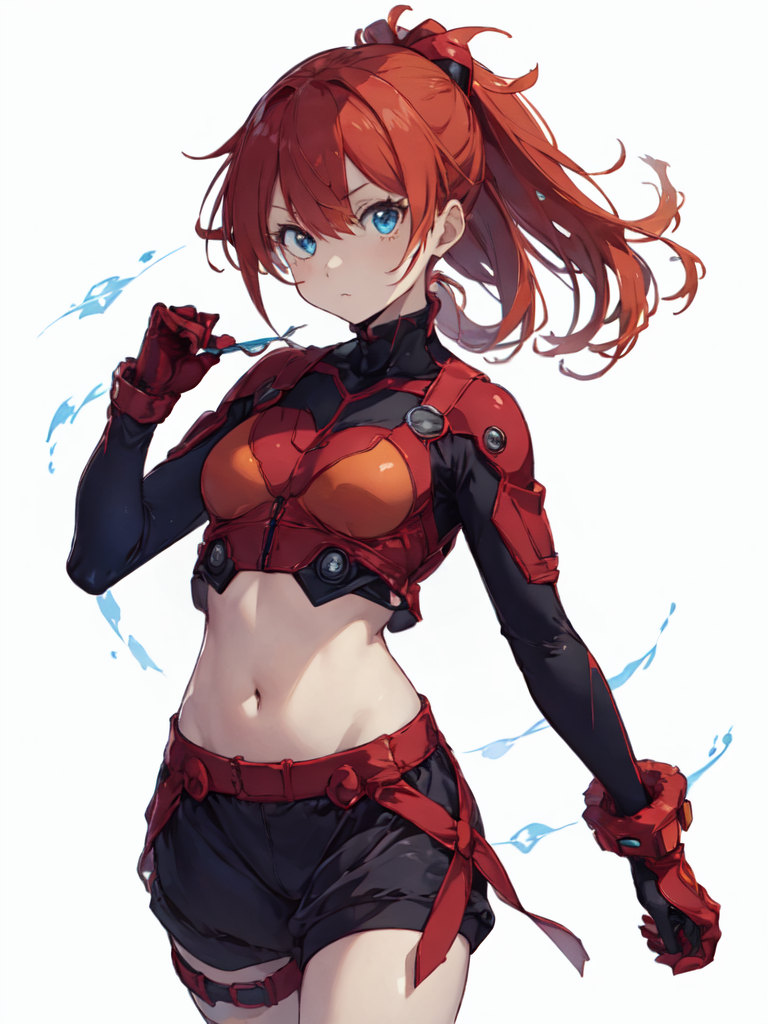

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image = cv2.imread('/content/00370-864768218.png')
cv2_imshow(image)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

from torch.utils.data import DataLoader

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN,self).__init__()

        self.conv = nn.Conv2d(1,
                              32, #32 kernels
                              3, #Kernels de 3x3
                              1)

        self.fully = nn.Linear(80000,1)


    def forward(self,x):

        x = self.conv(x)
        x = F.relu(x)  #Activacion ReLU

        #Para poder ver lo que pasa entremedio, tengo
        #que detachear el tensor de la red
        dt = x.detach().numpy()
        print(dt.shape)
        cv2_imshow(dt[0][0])
        cv2_imshow(dt[0][1])
        cv2_imshow(dt[0][2])
        cv2_imshow(dt[0][3])

        #Le aplico un max pooling de 5x5
        x = F.max_pool2d(x, 5)

        #Para poder ver lo que pasa entremedio, tengo
        #que detachear el tensor de la red
        dt = x.detach().numpy()
        print(dt.shape)
        cv2_imshow(dt[0][0])
        cv2_imshow(dt[0][1])
        cv2_imshow(dt[0][2])
        cv2_imshow(dt[0][3])

        #Para poder pasarlo a la capa fully, tiene que
        #estar en un unico vector
        x = torch.flatten(x, 1)
        x = self.fully(x)

        return x

Hasta que no instancie la clase no se crea la red

In [ ]:
model = MyCNN()

Aca empieza lo interesante. Mi red espera imagenes con unas cualiudades especificas. Puedo meter cualquier imagen, pero antes la tengo que transformar.

En el caso de mi red, espera imagenes de 256x256 y de un solo canal de color (escala de grises)

In [ ]:
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
resized_grayscale_image = cv2.resize(grayscale_image, (256, 256))

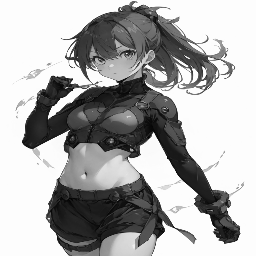

In [ ]:
cv2_imshow(resized_grayscale_image)

Por mucho que parezca, muchas veces este proceso no impacta negativamente en el resultado. Todas las imagenes que queramos usar en cualquier modelo las tenemos que preprocesar.

(1, 32, 254, 254)


<ipython-input-8-85861921c986>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  data = torch.tensor(images,dtype=torch.float32).reshape(len(images), 1, 256, 256)


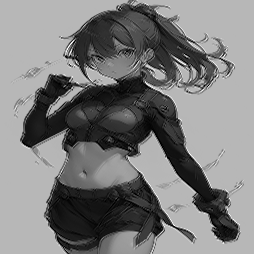

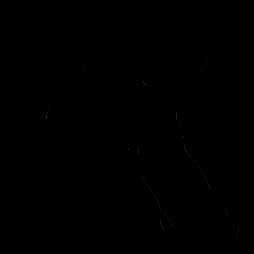

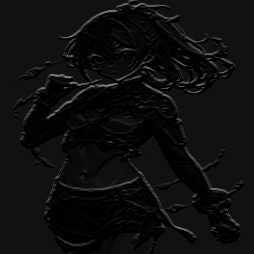

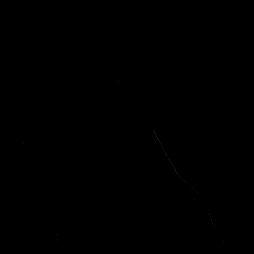

(1, 32, 50, 50)


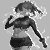

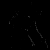

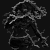

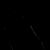

tensor([[18.8488]], grad_fn=<AddmmBackward0>)

In [ ]:
images = [resized_grayscale_image]
data = torch.tensor(images,dtype=torch.float32).reshape(len(images), 1, 256, 256)
model(data)

#Parte dos, no lo corras!

In [ ]:
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_vect(word):
    try:
        return w2v.get_vector(word)
    except KeyError:
        return np.zeros(300)

In [ ]:
!pip install datasets torchmetrics scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 6.7 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset,load_dataset

dataset = load_dataset("carblacac/twitter-sentiment-analysis")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/149985 [00:00<?, ? examples/s]

Map:   0%|          | 0/61998 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/120 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/62 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/119988 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29997 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/61998 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'feeling'],
        num_rows: 119988
    })
    validation: Dataset({
        features: ['text', 'feeling'],
        num_rows: 29997
    })
    test: Dataset({
        features: ['text', 'feeling'],
        num_rows: 61998
    })
})

In [ ]:
from nltk.tokenize import wordpunct_tokenize
wordpunct_tokenize("Hermes guile. And you".lower())

['hermes', 'guile', '.', 'and', 'you']

In [ ]:
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN,self).__init__()

        #Los kernels van a ser de 5*300 y pading va a tener
        #unicamente "vertical"
        self.conv = nn.Conv2d(1,512,(5,300),padding=(5,0))
        self.fully = nn.Linear(512,1)


    def forward(self,x):
        x = self.conv(x)  # 512 * [21,1]

        x = F.relu(x)

        #Pooleo absolutamente todo el resultado del kernel,
        #no tiene sentido hacerlo por partes
        x = F.max_pool2d(x, (36,1)) # 512

        x = torch.flatten(x, 1)
        x = self.fully(x)

        #Sigmoide para que los valores queden entre 0 y 1
        return F.sigmoid(x)

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def dataset_procesor(x):
    gen = (get_vect(w) #Obtengo el vector de cada palabra
                for w in  wordpunct_tokenize(x["text"].lower())
                    #Solo para las palabras que no sean stopwords y sean palabras
                    if w not in STOPWORDS and w.isalpha())

    #Lo hago todo float
    matrix = np.array(list(gen)).astype("float32")

    #Para no tener problemas en caso que todo el texto sea invalido
    if matrix.size < 1:
        matrix = np.zeros(300).astype("float32").reshape(1,-1)

    #Transformo la data a utilizar
    data = {
        "matrix": np.pad(matrix,pad_width=((0,30),(0, 0)))[:30],
        "label": np.array(x["feeling"]).astype("float32").reshape(1)
    }

    return data

In [ ]:
train_dataset = dataset["train"].map(dataset_procesor,remove_columns=["text","feeling"])
test_dataset = dataset["test"].map(dataset_procesor,remove_columns=["text","feeling"])

Map:   0%|          | 0/119988 [00:00<?, ? examples/s]

Map:   0%|          | 0/61998 [00:00<?, ? examples/s]

In [ ]:
model = TextCNN()

Chequeo que dispositivo es el de cuda, si no hay no estoy
trabajando con CUDA (duh)

In [ ]:
device = torch.device("cpu")
print(device)

cpu


Para no manejar yo los datos, torch tiene los dataloader que manejan el batch, el shuffle y demas

In [ ]:
train_dataloader = DataLoader(train_dataset.with_format("torch",device=device), batch_size=256,shuffle=True)
test_dataloader = DataLoader(test_dataset.with_format("torch",device=device), batch_size=256,shuffle=True)

In [ ]:
from torchmetrics.classification import BinaryAUROC, BinaryF1Score

criterion = nn.BCEWithLogitsLoss()

metric_a = BinaryAUROC(thresholds=None)
metric_b = BinaryF1Score(threshold=0.65)

model.to(device)

optimizer = torch.optim.Adam(model.parameters())

running_loss = 0
last_loss = 0
for i,data in enumerate(train_dataloader):

    #Muevo los tensors a la gpu
    inputs = data["matrix"].to(device)
    labels = data["label"].to(device)

    batch_size = len(inputs)

    #Reinicio los gradientes antes de pasar el batch
    optimizer.zero_grad()

    #Tengo que darle el shape que espera a la entrada
    inputs = inputs.reshape(batch_size,1,30,300)

    #Prediccion
    outputs = model(inputs)

    #Loss
    loss = criterion(outputs, labels)

    #Backward propagation del loss
    loss.backward()

    #Ajustamos los pesos
    optimizer.step()

    #Me guardo el loss para ir trackeando
    running_loss += loss.item()

    #Cada 100 batches reviso como va
    if i % 100 == 0:
        last_loss = running_loss / 100
        print('batch {} loss: {}'.format(i + 1, loss.item()))
        tb_x = i * len(train_dataloader) + i + 1
        print('Loss/train', last_loss, loss.item() ,  tb_x)
        running_loss = 0.


        with torch.no_grad():
            #A modo de prueba, veo como da en el dataset con
            #el que voy a medir mi modelo

            model.eval()

            preds = []
            for data in test_dataloader:

                inputs = data["matrix"].to(device)
                labels = data["label"].to(device)

                batch_size = len(inputs)
                inputs = inputs.reshape(batch_size,1,30,300)

                inputs = inputs.to(device)
                pred = model(inputs)

                #Le calculo la metrica que defini antes
                auc = metric_a(pred.reshape(batch_size), labels.reshape(batch_size))
                print("AUC",auc)

                f1 = metric_b(pred.reshape(batch_size), labels.reshape(batch_size))
                print("F1",f1)

                #Pero solo a un batch de 256
                break

print(last_loss)

batch 1 loss: 0.7159339785575867
Loss/train 0.007159339785575866 0.7159339785575867 1
AUC tensor(0.5504)
F1 tensor(0.)
batch 101 loss: 0.6509631872177124
Loss/train 0.654152267575264 0.6509631872177124 47001
AUC tensor(0.7974)
F1 tensor(0.5556)
batch 201 loss: 0.6194307208061218
Loss/train 0.6264333653450013 0.6194307208061218 94001
AUC tensor(0.8381)
F1 tensor(0.6968)
batch 301 loss: 0.6394522190093994
Loss/train 0.6232598221302033 0.6394522190093994 141001
AUC tensor(0.7967)
F1 tensor(0.6814)
batch 401 loss: 0.6184657216072083
Loss/train 0.62025071144104 0.6184657216072083 188001
AUC tensor(0.8398)
F1 tensor(0.6465)
0.62025071144104


In [ ]:
preds = []
labs = []
with torch.no_grad():
    model.eval()
    preds = []

    for data in test_dataloader:

        inputs = data["matrix"].to(device)
        labels = data["label"].to(device)

        batch_size = len(inputs)
        inputs = inputs.reshape(batch_size,1,30,300)

        inputs = inputs.to(device)
        pred = model(inputs)

        #Acumulo todo
        preds.append(pred)
        labs.append(labels)

In [ ]:
metric_a(torch.cat(preds).reshape(-1),torch.cat(labs).reshape(-1))

tensor(0.8287)

In [ ]:
metric_b(torch.cat(preds).reshape(-1),torch.cat(labs).reshape(-1))

tensor(0.6839)

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_probas, y_true = torch.cat(preds).reshape(-1),torch.cat(labs).reshape(-1)

print(y_probas.cpu().shape)
print(y_true.cpu().shape)

torch.Size([61998])
torch.Size([61998])


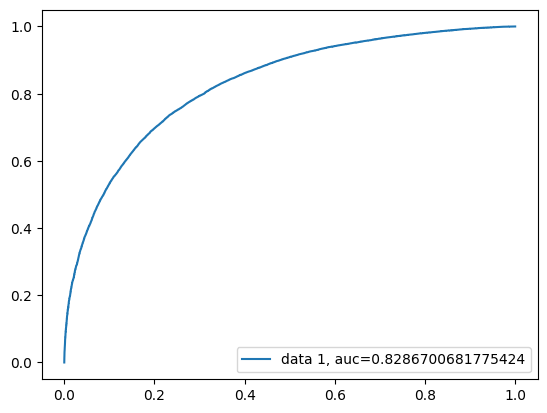

In [ ]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_true.cpu(),  y_probas.cpu())
auc = metrics.roc_auc_score(y_true.cpu(),  y_probas.cpu())

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
def to_tensor(x):
    gen = (get_vect(w) for w in  wordpunct_tokenize(x.lower()) if w not in STOPWORDS and w.isalpha())

    matrix = np.array(list(gen)).astype("float32")

    if matrix.size < 1:
        matrix = np.zeros(300).astype("float32").reshape(1,-1)

    return torch.from_numpy(np.pad(matrix,pad_width=((0,30),(0, 0)))[:30]).reshape(1,1,30,300)

In [ ]:
with torch.no_grad():
    model.eval()
    result = model(to_tensor("I'm happy").to(device))

print(result)

tensor([[0.9984]])


In [ ]:
song = """Doesn't seem to matter what I do
I'm always number two
No one knows how hard I tried, oh-oh
I, I have feelings that I can't explain
Drivin' me insane
All my life, been so polite
But I'll sleep alone tonight
'Cause I'm just Ken, anywhere else I'd be a ten
Is it my destiny to live and die a life of blonde fragility?
I'm just Ken
Where I see love, she sees a friend
What will it take for her to see the man behind the tan and fight for me?
I wanna know what it's like to love, to be the real thing
Is it a crime? Am I not hot when I'm in my feelings?
And is my moment finally here, or am I dreaming?
I'm no dreamer
Can you feel the Kenergy?
Feels so real, my Kenergy
Can you feel the Kenergy?
Feels so real, my Kenergy
I'm just Ken, anywhere else I'd be a ten
Is it my destiny to live and die a life of blonde fragility?
I'm just Ken
Where I see love, she sees a friend
What will it take for her to see the man behind the tan and fight for me?
I'm just Ken (and I'm enough)
And I'm great at doing stuff
So, hey! Check me out, yeah, I'm just Ken
My name's Ken (and so am I)
Put that manly hand in mine
So, hey! World, check me out, yeah, I'm just Ken
Baby, I'm just Ken (nobody else, nobody else, nobody)"""

In [ ]:
with torch.no_grad():
    model.eval()

    for x in song.split("\n"):
        result = model(to_tensor(x).to(device))

        print( x ,"\t\t" , result[0][0]>=0.65)

Doesn't seem to matter what I do 		 tensor(False)
I'm always number two 		 tensor(False)
No one knows how hard I tried, oh-oh 		 tensor(False)
I, I have feelings that I can't explain 		 tensor(False)
Drivin' me insane 		 tensor(False)
All my life, been so polite 		 tensor(True)
But I'll sleep alone tonight 		 tensor(False)
'Cause I'm just Ken, anywhere else I'd be a ten 		 tensor(False)
Is it my destiny to live and die a life of blonde fragility? 		 tensor(False)
I'm just Ken 		 tensor(False)
Where I see love, she sees a friend 		 tensor(True)
What will it take for her to see the man behind the tan and fight for me? 		 tensor(False)
I wanna know what it's like to love, to be the real thing 		 tensor(True)
Is it a crime? Am I not hot when I'm in my feelings? 		 tensor(False)
And is my moment finally here, or am I dreaming? 		 tensor(True)
I'm no dreamer 		 tensor(False)
Can you feel the Kenergy? 		 tensor(False)
Feels so real, my Kenergy 		 tensor(False)
Can you feel the Kenergy? 		 ten